In [99]:
# %% environment and functions
import numpy as np
import matplotlib.pyplot as plt
import os
import albumentations as A
join = os.path.join
from albumentations.core.composition import Compose
import torch
from segment_anything2 import sam_model_registry
from skimage import io, transform
import torch.nn.functional as F
import cv2

# visualization functions
# source: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
# change color to avoid red and green
def show_mask(mask, ax,random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251 / 255, 252 / 255, 30 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1)* color.reshape(1, 1, -1)
    ax.imshow(mask_image)

#MedSAM model for inference    
@torch.no_grad()
def medsam_inference(medsam_model, img_embed, H, W):
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed, # (B, 256, 64, 64)
        multimask_output=False,
        )
    low_res_pred = torch.sigmoid(low_res_logits)
    
    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )  # (1, 1, gt.shape)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()  # (256, 256)
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg



## Load model

In [100]:
#Original medsam weights
MedSAM_CKPT_PATH = "SAM/sam_vit_b_01ec64.pth" #Don't change this path

#Weights of fine-tunning medsam in LITS
LITS_CKPT_PATH= "LITS_CHECK_PATH"

#Select device
device = "cuda:0"

medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH,img_size=512,in_chans=1)
print("Original Checkpoint loaded")

medsam_model = medsam_model.to(device)
medsam_model.load_state_dict(torch.load(LITS_CKPT_PATH,map_location=device)["model"])
medsam_model.eval()
print("Ready to test!!")

Skip loading parameter: image_encoder.patch_embed.proj.weight, required shape: torch.Size([768, 1, 16, 16]), loaded shape: torch.Size([768, 3, 16, 16])
Skip loading parameter: image_encoder.blocks.2.attn.rel_pos_h, required shape: torch.Size([63, 64]), loaded shape: torch.Size([127, 64])
Skip loading parameter: image_encoder.blocks.2.attn.rel_pos_w, required shape: torch.Size([63, 64]), loaded shape: torch.Size([127, 64])
Skip loading parameter: image_encoder.blocks.5.attn.rel_pos_h, required shape: torch.Size([63, 64]), loaded shape: torch.Size([127, 64])
Skip loading parameter: image_encoder.blocks.5.attn.rel_pos_w, required shape: torch.Size([63, 64]), loaded shape: torch.Size([127, 64])
Skip loading parameter: image_encoder.blocks.8.attn.rel_pos_h, required shape: torch.Size([63, 64]), loaded shape: torch.Size([127, 64])
Skip loading parameter: image_encoder.blocks.8.attn.rel_pos_w, required shape: torch.Size([63, 64]), loaded shape: torch.Size([127, 64])
Skip loading parameter: im

## Select image

In [101]:
#Image path
image_path='IMAGE_PATH'

img_np = io.imread(image_path,as_gray=True)
if len(img_np.shape) == 2:
    img_3c = img_np[..., None]
else:
    img_3c = img_np
H, W, _ = img_3c.shape

## Image preprocessing and model inference

In [102]:
test_transform = Compose([
    A.Resize(512,512),
])
img_3c_resize = test_transform(image=img_3c)["image"]

img = img_3c_resize.astype("float32")/ 255
img = img.transpose(2, 0, 1)
img_tensor = torch.tensor(img).float()[None,...]
img_tensor=img_tensor.to(device)
with torch.no_grad():
    image_embedding = medsam_model.image_encoder(img_tensor) # (1, 256, 64, 64)
medsam_seg = medsam_inference(medsam_model, image_embedding, 512, 512)

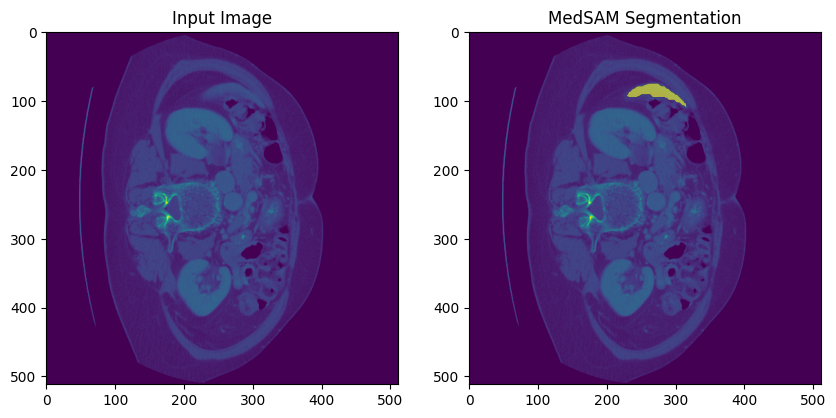

In [103]:
#%% visualize results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_3c_resize)
ax[0].set_title("Input Image")
ax[1].imshow(img_3c_resize)
show_mask(medsam_seg, ax[1])
ax[1].set_title("MedSAM Segmentation")
plt.show()